In [20]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

# Load dataset using UCI ML Repo API

In [21]:
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets


# Merge features and target for analysis
df = pd.concat([X, y], axis=1)

# Basic Profiling

In [22]:
print("\n\n[INFO] Dataset shape:", df.shape)



[INFO] Dataset shape: (45211, 17)


In [23]:
print("\n\n[INFO] Column types:")
print(df.dtypes)



[INFO] Column types:
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object


In [24]:
print("\n\n[INFO] Sample records:")
print(df.head())



[INFO] Sample records:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married        NaN      no     1506     yes   no   
4   33           NaN   single        NaN      no        1      no   no   

  contact  day_of_week month  duration  campaign  pdays  previous poutcome   y  
0     NaN            5   may       261         1     -1         0      NaN  no  
1     NaN            5   may       151         1     -1         0      NaN  no  
2     NaN            5   may        76         1     -1         0      NaN  no  
3     NaN            5   may        92         1     -1         0      NaN  no  
4     NaN            5   may       198         1     -1         0      NaN  no  


# SQL-based Exploration using DuckDB

In [25]:
print("\n\n[INFO] Top jobs by balance")
print(duckdb.query("""
SELECT job, AVG(balance) AS avg_balance, COUNT(*) AS count
FROM df
GROUP BY job
ORDER BY avg_balance DESC
""").to_df())



[INFO] Top jobs by balance
              job  avg_balance  count
0         retired  1984.215106   2264
1            None  1772.357639    288
2      management  1763.616832   9458
3   self-employed  1647.970868   1579
4      unemployed  1521.745971   1303
5    entrepreneur  1521.470074   1487
6       housemaid  1392.395161   1240
7         student  1388.060768    938
8      technician  1252.632092   7597
9          admin.  1135.838909   5171
10    blue-collar  1078.826654   9732
11       services   997.088108   4154


In [26]:
print("\n\n[INFO] Marital status distribution by outcome")
print(duckdb.query("""
SELECT marital, y, COUNT(*) as cnt
FROM df
GROUP BY marital, y
ORDER BY marital, y
""").to_df())



[INFO] Marital status distribution by outcome
    marital    y    cnt
0  divorced   no   4585
1  divorced  yes    622
2   married   no  24459
3   married  yes   2755
4    single   no  10878
5    single  yes   1912


# Feature Engineering

In [27]:
print("\n[INFO] Encoding target variable 'y'")
df['target'] = df['y'].map({"yes": 1, "no": 0})


[INFO] Encoding target variable 'y'


## 1. Ratio Features

In [28]:
print("[INFO] Adding ratio features")
df['balance_to_duration_ratio'] = df['balance'] / (df['duration'] + 1)
df['balance_per_campaign'] = df['balance'] / (df['campaign'] + 1)

[INFO] Adding ratio features


## 2. Binary Features from categorical

In [29]:
print("[INFO] Creating binary features from yes/no columns")
df['has_default'] = df['default'].map({'yes': 1, 'no': 0})
df['has_housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['has_loan'] = df['loan'].map({'yes': 1, 'no': 0})

[INFO] Creating binary features from yes/no columns


## 3. Ordinal encoding (e.g., education)

In [30]:
print("[INFO] Encoding education as ordinal feature")
education_order = {
'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3
}
df['education_level'] = df['education'].map(education_order)

[INFO] Encoding education as ordinal feature


## 4. Time-derived Features

In [31]:
print("[INFO] Adding time-based features")
month_map = {
'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['contact_month'] = df['month'].map(month_map)

[INFO] Adding time-based features


## Trying to build a weekday-like feature from `day` and `month` assuming dummy year

In [32]:
date_strs = df['day_of_week'].astype(str) + '-' + df['month'].astype(str).str[:3] + '-2008'
df['day_of_week'] = pd.to_datetime(date_strs, format='%d-%b-%Y', errors='coerce').dt.dayofweek

## 5. Interaction features

In [33]:
print("[INFO] Adding interaction feature: job_edu_combo")
df['job_edu_combo'] = df['education'].astype(str) + '_' + df['job'].astype(str)
df['job_edu_encoded'] = LabelEncoder().fit_transform(df['job_edu_combo'])

[INFO] Adding interaction feature: job_edu_combo


## 6. One-hot encoding

In [34]:
print("[INFO] One-hot encoding job and contact")
df = pd.get_dummies(df, columns=['job', 'contact'], prefix=['job', 'contact'])

[INFO] One-hot encoding job and contact


## 7. Frequency encoding

In [35]:
print("[INFO] Adding frequency-encoded marital status")
marital_freq = df['marital'].value_counts(normalize=True)
df['marital_freq'] = df['marital'].map(marital_freq)

[INFO] Adding frequency-encoded marital status


## 8. Age Binning

In [36]:
print("[INFO] Applying generator-based age binning")
def bin_age_generator(data, bin_size=10):
    for age in data:
        yield f"{(age // bin_size) * bin_size}-{((age // bin_size) + 1) * bin_size - 1}"
df['age_bin'] = list(bin_age_generator(df['age']))

[INFO] Applying generator-based age binning


## 9. Aggregation Example

In [37]:
print("[INFO] Group-based average duration per education level")
df['avg_duration_by_edu'] = df.groupby('education')['duration'].transform('mean')

[INFO] Group-based average duration per education level


# Visualization

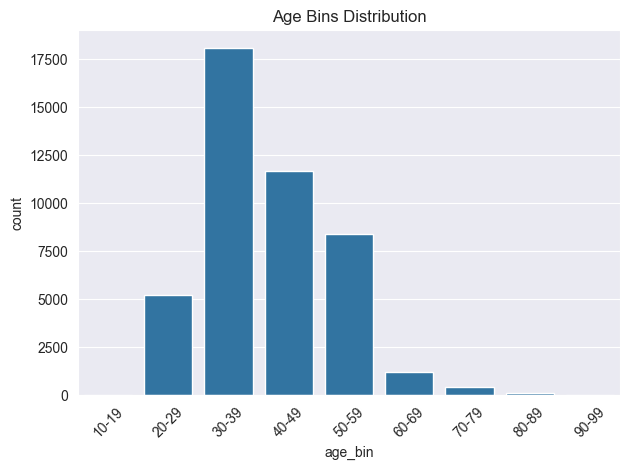

In [38]:
sns.countplot(data=df, x="age_bin", order=sorted(df['age_bin'].unique()))
plt.title("Age Bins Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
df.to_csv("../data/engineered_bank_data.csv", index=False)
print("\n[INFO] Feature engineered data saved as 'engineered_bank_data.csv'")


[INFO] Feature engineered data saved as 'engineered_bank_data.csv'


In [40]:
df.head()

,age,marital,education,default,balance,housing,loan,day_of_week,month,duration,...,job_self-employed,job_services,job_student,job_technician,job_unemployed,contact_cellular,contact_telephone,marital_freq,age_bin,avg_duration_by_edu
0,58,married,tertiary,no,2143,yes,no,0,may,261,...,False,False,False,False,False,False,False,0.601933,50-59,258.518532
1,44,single,secondary,no,29,yes,no,0,may,151,...,False,False,False,True,False,False,False,0.282896,40-49,258.685760
2,33,married,secondary,no,2,yes,yes,0,may,76,...,False,False,False,False,False,False,False,0.601933,30-39,258.685760
3,47,married,NaN,no,1506,yes,no,0,may,92,...,False,False,False,False,False,False,False,0.601933,40-49,NaN
4,33,single,NaN,no,1,no,no,0,may,198,...,False,False,False,False,False,False,False,0.282896,30-39,NaN
